[INFO] loading images...


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[INFO] compiling model...
[INFO] training head...
Epoch 1/15
122/122 [==============================] - 147s 1s/step - loss: 0.3744 - accuracy: 0.8619 - val_loss: 0.1299 - val_accuracy: 0.9831
Epoch 2/15
122/122 [==============================] - 168s 1s/step - loss: 0.1354 - accuracy: 0.9665 - val_loss: 0.0680 - val_accuracy: 0.9883
Epoch 3/15
122/122 [==============================] - 195s 2s/step - loss: 0.0902 - accuracy: 0.9760 - val_loss: 0.0480 - val_accuracy: 0.9896
Epoch 4/15
122/122 [==============================] - 184s 2s/step - loss: 0.0782 - accuracy: 0.9770 - val_loss: 0.0403 - val_accuracy: 0.9909
Epoch 5/15
122/122 [==============================] - 177s 1s/step - loss: 0.0670 - accuracy: 0.9799 - val_loss: 0.0369 - val_accuracy: 0.9909
Epoch 6/15
122/122 [==============================] - 189s 2s/step - loss: 0.0592 - accuracy: 0.9816 - val_loss: 0.0369 - val_accuracy: 0.9896
Epoch 7/15
122/122 [==============================] - 184s 2s/step - loss: 0.0499 - accuracy

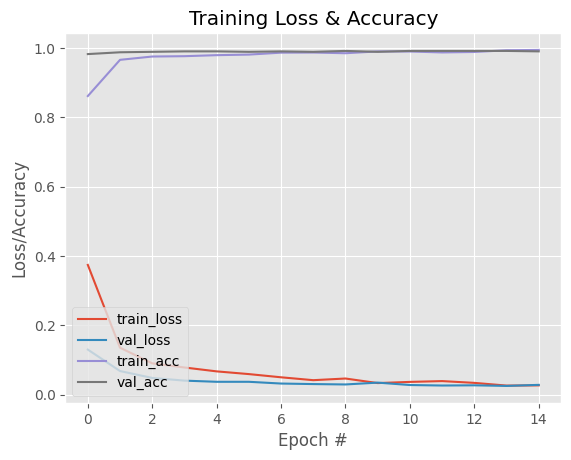

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


INIT_LR = 1e-4    # initialize the initial learning rate
EPOCHS = 15     # number of epochs to train for
BS = 25           # batch size for training


DIRECTORY = r"E:/AIUB/10th Semester/CVPR/final_assignment/Assignment_01/dataset"
CATEGORIES = ["with_mask", "without_mask"]

print("[INFO] loading images...")


data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)


lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)



# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss & Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("img_plot.png")


